In [85]:
import numpy as np

#Defining the DataSet
from qiskit_aer import AerSimulator
from sklearn import datasets
from sklearn.model_selection import train_test_split

SEED = 1231
qasm_sim = AerSimulator()

x,y = datasets.make_moons(n_samples=100, noise=0.1, random_state=SEED)
# Normalizatin
x[:,0] = x[:,0] / (np.max(x[:,0]) - np.min(x[:,0]))
x[:,1] = x[:,1] / (np.max(x[:,1]) - np.min(x[:,1]))

num_classes = 2
num_features = 2
dimension = 2
x_blue = x[y==0]
x_red = x[y==1]

test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=SEED, stratify=y)

In [86]:
# Plot of the dataset

import matplotlib.pyplot as plt
import numpy as np



def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(x_train, y_train,x_test, y_test):

# train_features, train_labels, test_features, test_labels
    plt.figure(figsize=(5, 5))
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    # plt.imshow(
    #     np.asmatrix(adhoc_total).T,
    #     interpolation="nearest",
    #     origin="lower",
    #     cmap="RdBu",
    #     extent=[0, 2 * np.pi, 0, 2 * np.pi],
    # )

    # A train plot
    plot_features(plt, x_train,  y_train, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, x_train,  y_train, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, x_test, y_test, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, x_test, y_test, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

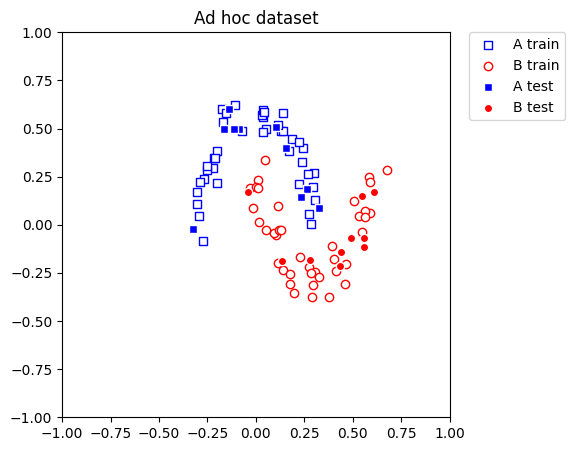

In [87]:
plot_dataset(x_train, y_train,x_test, y_test)


In [95]:
# Define the Kernel as K(x,y) = |<ψ(x)|ψ(y)>|^2  ie fidelity estimation
#since the K(x,y) is dependant on the feature map, we define it here too

from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import ZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

#definition of the quantum feature map
# We can change this feature map for testing multiple feature map
# feature_map = ZZFeatureMap(feature_dimension=dimension, reps=3, entanglement="linear")
feature_map = ZZFeatureMap(feature_dimension=dimension, reps=3)

#Here, we could define the Sampler for estimation of the fidelity/overlap K(x,y)
#sampler = Sampler()

# Wraps the feature map, the sampler and the fidelity estimator in kernel
kernel = FidelityQuantumKernel(feature_map=feature_map)


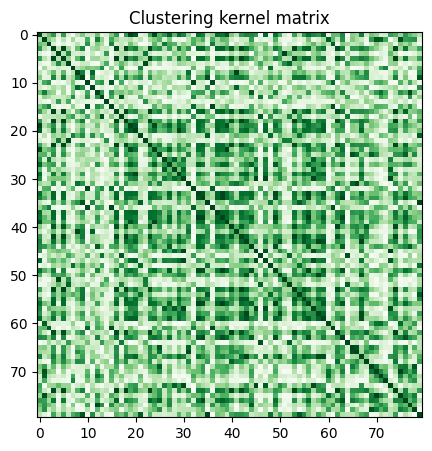

In [96]:
matrix = kernel.evaluate(x_vec=x_train)
# matrix_test = kernel.evaluate(x_vec=x_train, y_vec = y_test)

plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(matrix), interpolation="nearest", origin="upper", cmap="Greens")
plt.title("Clustering kernel matrix")
plt.show()

In [97]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

spectral = SpectralClustering(2, affinity="precomputed")

cluster_labels = spectral.fit_predict(matrix)

cluster_score = normalized_mutual_info_score(cluster_labels, y_train)

print(f"Clustering score: {cluster_score}")

Clustering score: 0.0026584772076750996


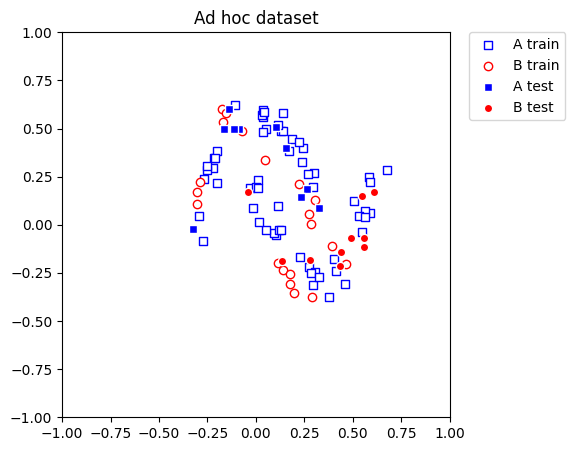

In [98]:
plot_dataset(x_train, cluster_labels,x_test, y_test)


In [99]:
# Use PCA to see the separation of the projection

from sklearn.decomposition import KernelPCA

kernel_pca_q = KernelPCA(n_components=2, kernel="precomputed")
train_features_q = kernel_pca_q.fit_transform(matrix)
# test_features_q = kernel_pca_q.transform(matrix_test)

In [100]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression.fit(train_features_q, y_train)

# logistic_score = logistic_regression.score(test_features_q, y_test)
# print(f"Logistic regression score: {logistic_score}")

LogisticRegression()

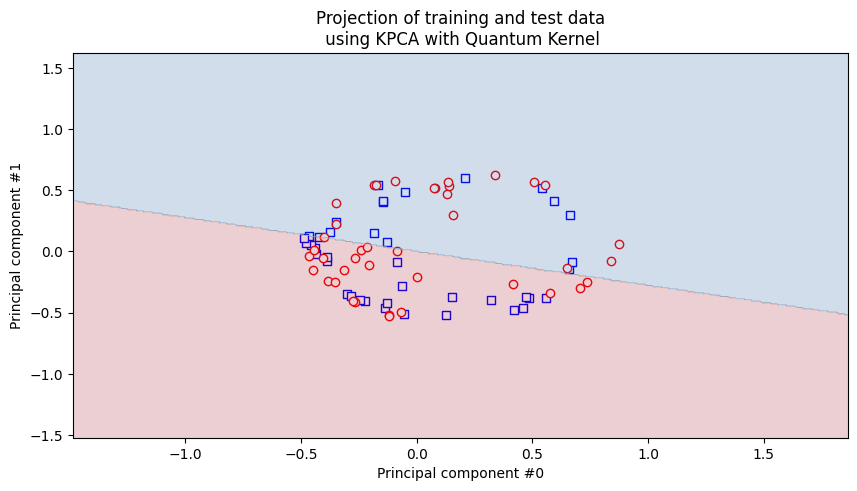

In [102]:
fig, (q_ax) = plt.subplots(1, 1, figsize=(10, 5))


plot_features(q_ax, train_features_q, y_train, 0, "s", "w", "b", "A train")
plot_features(q_ax, train_features_q, y_train, 1, "o", "w", "r", "B train")

# plot_features(q_ax, test_features_q, test_labels, 0, "s", "b", "w", "A test")
# plot_features(q_ax, test_features_q, test_labels, 1, "o", "r", "w", "A test")

q_ax.set_ylabel("Principal component #1")
q_ax.set_xlabel("Principal component #0")
q_ax.set_title("Projection of training and test data\n using KPCA with Quantum Kernel")

# Plotting the linear separation
h = 0.01  # step size in the mesh

# create a mesh to plot in
x_min, x_max = train_features_q[:, 0].min() - 1, train_features_q[:, 0].max() + 1
y_min, y_max = train_features_q[:, 1].min() - 1, train_features_q[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

predictions = logistic_regression.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
predictions = predictions.reshape(xx.shape)
q_ax.contourf(xx, yy, predictions, cmap=plt.cm.RdBu, alpha=0.2)

plt.show()